<a href="https://colab.research.google.com/github/BasemSuleiman/Intelligent_Failure_Prediction/blob/main/FL%20Evaluation%20Anomaly%20IoT%20Smart%20home%20Win%20Internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
import torch.nn as nn
import torch
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10,MNIST
import numpy as np
from PIL import Image
import torchvision
from torchsummary import summary
from sklearn.metrics import roc_auc_score,f1_score
import torch.optim as optim
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq
import argparse
import glob
import imageio
import matplotlib.pyplot as plt
import time
import os
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm
from scipy.stats import norm
from IPython import display

# imports for fedprox

import copy
import random

import gc

In [ ]:
import os
from io import StringIO
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# downloaded = drive.CreateFile({'id':'1Qr4sGKHIFswvdgnK0cB0n-x5Lm36K1d8'}) 
# downloaded.GetContentFile('COMPASS-XP_split.zip') 
# !unzip COMPASS-XP_split.zip

# Data prepocessing

In [ ]:
def get_mnist_anomaly_dataset(train_ds, valid_ds, abn_cls_idx=0):
    """[summary]
    Arguments:
        train_ds {Dataset - MNIST} -- Training dataset
        valid_ds {Dataset - MNIST} -- Validation dataset.
    Keyword Arguments:
        abn_cls_idx {int} -- Anomalous class index (default: {0})
    Returns:
        [np.array] -- New training-test images and labels.
    """

    # Get images and labels.
    trn_img, trn_lbl = train_ds.data, train_ds.targets
    tst_img, tst_lbl = valid_ds.data, valid_ds.targets

    # --
    # Find normal abnormal indexes.
    # TODO: PyTorch v0.4 has torch.where function
    nrm_trn_idx = torch.from_numpy(np.where(trn_lbl.numpy() != abn_cls_idx)[0])
    abn_trn_idx = torch.from_numpy(np.where(trn_lbl.numpy() == abn_cls_idx)[0])
    nrm_tst_idx = torch.from_numpy(np.where(tst_lbl.numpy() != abn_cls_idx)[0])
    abn_tst_idx = torch.from_numpy(np.where(tst_lbl.numpy() == abn_cls_idx)[0])

    # --
    # Find normal and abnormal images
    nrm_trn_img = trn_img[nrm_trn_idx]    # Normal training images
    abn_trn_img = trn_img[abn_trn_idx]    # Abnormal training images.
    nrm_tst_img = tst_img[nrm_tst_idx]    # Normal training images
    abn_tst_img = tst_img[abn_tst_idx]    # Abnormal training images.

    # --
    # Find normal and abnormal labels.
    nrm_trn_lbl = trn_lbl[nrm_trn_idx]    # Normal training labels
    abn_trn_lbl = trn_lbl[abn_trn_idx]    # Abnormal training labels.
    nrm_tst_lbl = tst_lbl[nrm_tst_idx]    # Normal training labels
    abn_tst_lbl = tst_lbl[abn_tst_idx]    # Abnormal training labels.

    # --
    # Assign labels to normal (0) and abnormals (1)
    nrm_trn_lbl[:] = 0
    nrm_tst_lbl[:] = 0
    abn_trn_lbl[:] = 1
    abn_tst_lbl[:] = 1

    # Create new anomaly dataset based on the following data structure:
    train_ds.data = nrm_trn_img.clone()
    valid_ds.data = torch.cat((nrm_tst_img, abn_trn_img, abn_tst_img), dim=0)
    
    train_ds.targets = nrm_trn_lbl.clone()
    valid_ds.targets = torch.cat((nrm_tst_lbl, abn_trn_lbl, abn_tst_lbl), dim=0)
    
    print("train_ds len", len(train_ds))
    print("valid_ds len", len(valid_ds))

    return train_ds, valid_ds

In [ ]:
def get_cifar_anomaly_dataset(train_ds, valid_ds, abn_cls_idx=5):

    # Get images and labels.
    trn_img, trn_lbl = train_ds.data, np.array(train_ds.targets)
    tst_img, tst_lbl = valid_ds.data, np.array(valid_ds.targets)

    # --
    # Find idx, img, lbl for abnormal and normal on org dataset.
    nrm_trn_idx = np.where(trn_lbl != abn_cls_idx)[0]
    abn_trn_idx = np.where(trn_lbl == abn_cls_idx)[0]
    nrm_trn_img = trn_img[nrm_trn_idx]    # Normal training images
    abn_trn_img = trn_img[abn_trn_idx]    # Abnormal training images
    nrm_trn_lbl = trn_lbl[nrm_trn_idx]    # Normal training labels
    abn_trn_lbl = trn_lbl[abn_trn_idx]    # Abnormal training labels.

    nrm_tst_idx = np.where(tst_lbl != abn_cls_idx)[0]
    abn_tst_idx = np.where(tst_lbl == abn_cls_idx)[0]
    nrm_tst_img = tst_img[nrm_tst_idx]    # Normal testing images
    abn_tst_img = tst_img[abn_tst_idx]    # Abnormal testing images.
    nrm_tst_lbl = tst_lbl[nrm_tst_idx]    # Normal testing labels
    abn_tst_lbl = tst_lbl[abn_tst_idx]    # Abnormal testing labels.

    # --
    # Assign labels to normal (0) and abnormals (1)
    nrm_trn_lbl[:] = 0
    nrm_tst_lbl[:] = 0
    abn_trn_lbl[:] = 1
    abn_tst_lbl[:] = 1

    train_ds.data = np.copy(nrm_trn_img)
    valid_ds.data = np.concatenate((nrm_tst_img, abn_trn_img, abn_tst_img), axis=0)
    train_ds.targets = np.copy(nrm_trn_lbl)
    valid_ds.targets = np.concatenate((nrm_tst_lbl, abn_trn_lbl, abn_tst_lbl), axis=0)

    return train_ds, valid_ds
    # Create new anomaly dataset based on the following data structure:
    # - anomaly dataset
    #   . -> train
    #        . -> normal
    #   . -> test
    #        . -> normal
    #        . -> abnormal

In [ ]:
def load_data(dataset,abnormal_class,image_size,batch_size):

    # LOAD DATA SET
    if dataset in ['cifar10']:

        transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )

        classes = {
            'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
            'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
        }

        train_ds = CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_ds = CIFAR10(root='./data', train=False, download=True, transform=transform)

        train_ds, valid_ds = get_cifar_anomaly_dataset(train_ds, test_ds, classes[abnormal_class])
        train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        valid_dl = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True, drop_last=False)

        return train_dl,valid_dl

    elif dataset in ['mnist']:

        transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
        train_ds = MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds = MNIST(root='./data', train=False, download=True, transform=transform)

        train_ds, valid_ds = get_mnist_anomaly_dataset(train_ds, test_ds, abnormal_class)
        train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        valid_dl = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True, drop_last=False)

        return train_dl,valid_dl

    else:
        train_path = '/content/COMPASS-XP_split/train/Colour'
        train_transforms = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.8986, 0.8280, 0.6925), (0.2222, 0.1950, 0.2224))
        ])
        test_path = '/content/COMPASS-XP_split/test/Colour'
        test_transforms = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.8986, 0.8280, 0.6925), (0.2222, 0.1950, 0.2224))
        ])
        train_images = torchvision.datasets.ImageFolder(root = train_path, transform = train_transforms)
        test_images = torchvision.datasets.ImageFolder(root = test_path, transform = test_transforms)

        train_dl = DataLoader(dataset=train_images, batch_size=batch_size, shuffle=True)
        valid_dl = DataLoader(dataset=test_images, batch_size=batch_size, shuffle=True)

        return train_dl,valid_dl

# Models

In [ ]:
class Encoder(nn.Module):
    """
    DCGAN ENCODER NETWORK
    """

    def __init__(self, imageSize, nz, nc, ndf, ngpu, n_extra_layers=0, add_final_conv=True):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        assert imageSize % 16 == 0, "imageSize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x imageSize x imageSize
        main.add_module('initial-conv-{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial-relu-{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = imageSize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}-{1}-conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}-{1}-batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}-{1}-relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid-{0}-{1}-conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid-{0}-batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid-{0}-relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        if add_final_conv:
            main.add_module('final-{0}-{1}-conv'.format(cndf, 1),
                            nn.Conv2d(cndf, nz, 4, 1, 0, bias=False))

        self.main = main

    def forward(self, input):
        if self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output

##
class Decoder(nn.Module):
    """
    DCGAN DECODER NETWORK
    """
    def __init__(self, imageSize, nz, nc, ngf, ngpu, n_extra_layers=0):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        assert imageSize % 16 == 0, "imageSize has to be a multiple of 16"

        cngf, timageSize = ngf // 2, 4
        while timageSize != imageSize:
            cngf = cngf * 2
            timageSize = timageSize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial-{0}-{1}-convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial-{0}-batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial-{0}-relu'.format(cngf),
                        nn.ReLU(True))

        csize, _ = 4, cngf
        while csize < imageSize // 2:
            main.add_module('pyramid-{0}-{1}-convt'.format(cngf, cngf // 2),
                            nn.ConvTranspose2d(cngf, cngf // 2, 4, 2, 1, bias=False))
            main.add_module('pyramid-{0}-batchnorm'.format(cngf // 2),
                            nn.BatchNorm2d(cngf // 2))
            main.add_module('pyramid-{0}-relu'.format(cngf // 2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}-{1}-conv'.format(t, cngf),
                            nn.Conv2d(cngf, cngf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}-{1}-batchnorm'.format(t, cngf),
                            nn.BatchNorm2d(cngf))
            main.add_module('extra-layers-{0}-{1}-relu'.format(t, cngf),
                            nn.ReLU(True))

        main.add_module('final-{0}-{1}-convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final-{0}-tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        if self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


##
class NetD(nn.Module):
    """
    DISCRIMINATOR NETWORK
    """

    def __init__(self, opt):
        super(NetD, self).__init__()
        model = Encoder(opt.imageSize, 1, opt.nc, opt.ngf, opt.ngpu, opt.n_extra_layers)
        layers = list(model.main.children())

        self.features = nn.Sequential(*layers[:-1])
        self.classifier = nn.Sequential(layers[-1])
        self.classifier.add_module('Sigmoid', nn.Sigmoid())

    def forward(self, x):
        features = self.features(x)
        features = features
        classifier = self.classifier(features)
        classifier = classifier.view(-1, 1).squeeze(1)

        return classifier, features

##
class NetG(nn.Module):
    """
    GENERATOR NETWORK
    """

    def __init__(self, opt):
        super(NetG, self).__init__()
        self.encoder1 = Encoder(opt.imageSize, opt.nz, opt.nc, opt.ngf, opt.ngpu, opt.n_extra_layers)
        self.decoder = Decoder(opt.imageSize, opt.nz, opt.nc, opt.ngf, opt.ngpu, opt.n_extra_layers)
        self.encoder2 = Encoder(opt.imageSize, opt.nz, opt.nc, opt.ngf, opt.ngpu, opt.n_extra_layers)

    def forward(self, x):
        latent_i = self.encoder1(x)
        gen_imag = self.decoder(latent_i)
        latent_o = self.encoder2(gen_imag)
        return gen_imag, latent_i, latent_o


def print_net():
    class OPT:
        def __init__(self, imageSize, nz, nc, ngf, ngpu, n_extra_layers):
            self.imageSize = imageSize
            self.nz = nz
            self.nc = nc
            self.ngf = ngf
            self.ngpu = ngpu
            self.n_extra_layers = n_extra_layers
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    opt = OPT(128, 100, 3, 64, 1, 0)
    gen = NetG(opt).to(device)
    opt = OPT(128, 1, 3, 64, 1, 0)
    disc = NetD(opt).to(device)
    summary(gen, (3, 128, 128))
    summary(disc, (3, 128, 128))

print_net()
class OPT:
    def __init__(self, imageSize, nz, nc, ngf, ngpu, n_extra_layers):
        self.imageSize = imageSize
        self.nz = nz
        self.nc = nc
        self.ngf = ngf
        self.ngpu = ngpu
        self.n_extra_layers = n_extra_layers

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
        LeakyReLU-14           [-1, 102

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)


## model
def training(lambda_dic,dataset,abnormal_class,opt_gen,opt_disc,train_dl,valid_dl,lr,n_epoches):

    gen = NetG(opt_gen).to(device)
    disc = NetD(opt_disc).to(device)
    gen.apply(weights_init)
    disc.apply(weights_init)

    lr = lr
    lambda_adv = lambda_dic['lambda_adv']
    lambda_con = lambda_dic['lambda_con']
    lambda_enc = lambda_dic['lambda_enc']
    ## loss function

    gen_optimizer = optim.AdamW(gen.parameters(), lr=lr)
    disc_optimizer = optim.AdamW(disc.parameters(), lr=lr)
    L_adv = nn.MSELoss()        # For gen
    L_con = nn.L1Loss()         # For gen
    L_enc = nn.MSELoss()        # For gen
    L_bce = nn.BCELoss()        # For disc

    n_epoches = n_epoches
    best_auc = 0
    print('=' * 100)
    print('Training the model with following configs: dataset = {} & abnormal_class = {}'.format(
        dataset, abnormal_class))
    print('=' * 100)
    for i in range(n_epoches):
            gen.train()
            disc.train()
            epoch_start_time = time.time()
            start_time = time.time()
            dataSize = 0
            L_adv_epoch_loss = 0.0
            L_con_epoch_loss = 0.0
            L_enc_epoch_loss = 0.0
            L_total_epoch_loss = 0.0
            disc_epoch_loss = 0.0
            for inputs, _ in train_dl:
                batch_size = inputs.size(0)
                dataSize += batch_size
                inputs = inputs.to(device)
                label_fake = torch.ones(batch_size).to(device)
                label_real = torch.zeros(batch_size).to(device)

                ## Update "D": max log(D(x)) + log(1-D(G(z))
                disc_optimizer.zero_grad()
                D_real, _ = disc(inputs)
                disc_loss_real = L_bce(D_real, label_real)
                outputs, _, _ = gen(inputs)
                D_fake, _ = disc(outputs.detach())
                
                disc_loss_fake = L_bce(D_fake, label_fake)
                disc_loss = (disc_loss_fake + disc_loss_real) * 0.5
                disc_loss.backward()
                disc_optimizer.step()
                disc_epoch_loss += disc_loss.item() * batch_size

                ## Update 'G' : max log(D(G(z)))
                gen_optimizer.zero_grad()
                outputs, latent_in, latent_out = gen(inputs)
                _, feature_fake = disc(outputs)
                _, feature_real = disc(inputs)
                adv_loss = L_adv(feature_fake, feature_real.detach())
                con_loss = L_con(outputs, inputs)
                enc_loss = L_enc(latent_out, latent_in)
                total_loss = lambda_adv * adv_loss + \
                            lambda_con * con_loss + \
                            lambda_enc * enc_loss
                total_loss.backward()
                L_adv_epoch_loss += adv_loss.item() * batch_size
                L_con_epoch_loss += con_loss.item() * batch_size
                L_enc_epoch_loss += enc_loss.item() * batch_size
                L_total_epoch_loss += total_loss.item() * batch_size

                gen_optimizer.step()

            ## End of epoch
            L_adv_epoch_loss /= dataSize
            L_con_epoch_loss /= dataSize
            L_enc_epoch_loss /= dataSize
            L_total_epoch_loss /= dataSize
            disc_epoch_loss /= dataSize

            L_enc = nn.MSELoss()
            #testing:
            gen.eval()
            disc.eval()
            enc_loss = []
            scores = []
            labels = []
            
            for test_input, label in valid_dl:
                test_input = test_input.to(device)

                with torch.no_grad():
                    outputs, latent_in, latent_out = gen(test_input)

                rec = torch.mean(torch.pow((latent_in-latent_out), 2), dim=1).cpu()
                enc_loss.extend(np.array(rec.reshape(rec.size(0))))
                labels += label     

            enc_loss = np.array(enc_loss)
            labels = np.array(labels)
            scores = (enc_loss - np.min(enc_loss)) / (np.max(enc_loss) - np.min(enc_loss))
            roc_auc = roc_auc_score(labels, scores)

            if roc_auc > best_auc:
                best_auc = roc_auc
                torch.save({
                            'epoch': i+1,
                            'gen_state_dict': gen.state_dict(),
                            'gen_optimizer_state_dict': gen_optimizer.state_dict(),
                            'disc_state_dict': disc.state_dict(),
                            'disc_optimizer_state_dict': disc_optimizer.state_dict(),
                            'Best_auc': best_auc,
                            }, '{}_{}_best_auc.pth'.format(dataset,abnormal_class))


            scores[scores >= 0.2] = 1
            scores[scores < 0.2] = 0
            f1 = f1_score(labels, scores)
            start_time = time.time()
            print('| Epoch:{} | time: {:5.2f}s | gen_epoch_loss:{:.8f} | disc_epoch_loss:{:.8f} '.format(i+1,
                                                                                                         (time.time() - epoch_start_time),
                                                                                                         L_total_epoch_loss, 
                                                                                                         disc_epoch_loss))
            print('-' * 90)
            print('          | Test AUC = {:.5f} | Best AUC = {} | Test F1 = {:.5f}'.format(roc_auc,best_auc,f1))
            print('-' * 90)
    print('=' * 100)
    return best_auc
        

# MNIST Training

## Class 0

In [ ]:
# lambda_dic = {
#     'lambda_adv' : 1,
#     'lambda_con' : 20,
#     'lambda_enc' : 20
# }    
# opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
# opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 0,image_size = 32,batch_size = 256)
# mnist_best_auc_0 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 0,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 1

In [ ]:
# lambda_dic = {
#     'lambda_adv' : 1,
#     'lambda_con' : 20,
#     'lambda_enc' : 20
# }    
# opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
# opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 1,image_size = 32,batch_size = 256)
# mnist_best_auc_1 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 1,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 2

In [ ]:
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 2,image_size = 32,batch_size = 256)
# mnist_best_auc_2 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 2,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 3

In [ ]:
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 3,image_size = 32,batch_size = 256)
# mnist_best_auc_3 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 3,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 4

In [ ]:
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 4,image_size = 32,batch_size = 256)
# mnist_best_auc_4 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 4,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 5

In [ ]:
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 5,image_size = 32,batch_size = 256)
# mnist_best_auc_5 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 5,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 6

In [ ]:
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 6,image_size = 32,batch_size = 256)
# mnist_best_auc_6 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 6,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 7

In [ ]:
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 7,image_size = 32,batch_size = 256)
# mnist_best_auc_7 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 7,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 8

In [ ]:
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 8,image_size = 32,batch_size = 256)
# mnist_best_auc_8 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 8,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Class 9

In [ ]:
# train_dl, valid_dl = load_data(dataset = 'mnist',abnormal_class = 9,image_size = 32,batch_size = 256)
# mnist_best_auc_9 = training(lambda_dic = lambda_dic,
#                             dataset = 'mnist',
#                             abnormal_class = 9,
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0001,
#                             n_epoches = 15
#                             )

## Cifar10

In [ ]:
# lambda_dic = {
#     'lambda_adv' : 1,
#     'lambda_con' : 20,
#     'lambda_enc' : 20
# }    
# opt_gen = OPT(imageSize=64, nz=100, nc=3, ngf=64, ngpu=0, n_extra_layers=0)
# opt_disc = OPT(imageSize=64, nz=1, nc=3, ngf=64, ngpu=0, n_extra_layers=0)
# train_dl, valid_dl = load_data(dataset = 'cifar10',abnormal_class = 0,image_size = 64,batch_size = 256)
# mnist_best_auc_0 = training(lambda_dic = lambda_dic,
#                             dataset = 'cifar10',
#                             abnormal_class = 'truck', # change different abnormal class here 
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.0002,
#                             n_epoches = 15
#                             )

## Compass 


In [ ]:
# lambda_dic = {
#     'lambda_adv' : 1,
#     'lambda_con' : 20,
#     'lambda_enc' : 20
# }    
# opt_gen = OPT(imageSize=128, nz=100, nc=3, ngf=128, ngpu=0, n_extra_layers=0)
# opt_disc = OPT(imageSize=128, nz=1, nc=3, ngf=128, ngpu=0, n_extra_layers=0)
# train_dl, valid_dl = load_data(dataset = 'compass',abnormal_class = 0,image_size = 128,batch_size = 64)
# mnist_best_auc_0 = training(lambda_dic = lambda_dic,
#                             dataset = 'compass',
#                             abnormal_class = '',
#                             opt_gen = opt_gen,
#                             opt_disc = opt_disc,
#                             train_dl = train_dl,
#                             valid_dl = valid_dl,
#                             lr = 0.001,
#                             n_epoches = 15
#                             )

# Federated Learning

In [ ]:
# this takes in a dataset and does image augmentation, then returns dataloaders (training and valid dl's)


def load_FL_data(dataset,abnormal_class,image_size,batch_size,num_clients):

    # LOAD DATA SET
    if dataset in ['cifar10']:

        transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )

        classes = {
            'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
            'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
        }

        train_ds = CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_ds = CIFAR10(root='./data', train=False, download=True, transform=transform)

        train_ds, valid_ds = get_cifar_anomaly_dataset(train_ds, test_ds, classes[abnormal_class])

        len_list = []
        n = int(len(train_ds) / num_clients)
        for _ in range(num_clients - 1):
          len_list.append(n)
        len_list.append(len(train_ds) - n*(num_clients - 1))
        
        traindata_split = torch.utils.data.random_split(train_ds, len_list)

        train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
        valid_dl = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True, drop_last=False)

        return train_loader,valid_dl
    

    elif dataset in ['mnist']:

        transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
        train_ds = MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds = MNIST(root='./data', train=False, download=True, transform=transform)

        train_ds, valid_ds = get_mnist_anomaly_dataset(train_ds, test_ds, abnormal_class)

        len_list = []
        n = int(len(train_ds) / num_clients)
        for _ in range(num_clients - 1):
          len_list.append(n)
        len_list.append(len(train_ds) - n*(num_clients - 1))
  
        traindata_split = torch.utils.data.random_split(train_ds, len_list)

            
        train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]

            
            
    
        valid_dl = DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=True, drop_last=False)

        return train_loader,valid_dl

    else:
        train_path = '/content/drive/MyDrive/Capstone/COMPASS-XP_split/train/Colour'
        train_transforms = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            #transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.8986, 0.8280, 0.6925), (0.2222, 0.1950, 0.2224))
        ])
        test_path = '/content/drive/MyDrive/Capstone/COMPASS-XP_split/test/Colour'
        test_transforms = transforms.Compose([
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.8986, 0.8280, 0.6925), (0.2222, 0.1950, 0.2224))
        ])
        train_images = torchvision.datasets.ImageFolder(root = train_path, transform = train_transforms)
        test_images = torchvision.datasets.ImageFolder(root = test_path, transform = test_transforms)

        len_list = []
        n = int(len(train_images) / num_clients)
        for _ in range(num_clients - 1):
          len_list.append(n)
        len_list.append(len(train_images) - n*(num_clients - 1))
        traindata_split = torch.utils.data.random_split(train_images, len_list)

        train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
        valid_dl = DataLoader(dataset=test_images, batch_size=batch_size, shuffle=True, drop_last=False)

        return train_loader,valid_dl

In [ ]:
## this function will take in a list of numbers and return the INDICES of the values which are median and below
# intended to take in a list of client losses

def get_median_indices(num_list):
    
    enum_ls = list(enumerate(num_list)) # give each client an index
    enum_ls.sort(key = lambda x: x[1]) # list is now sorted by loss in ascending order
    
    #remove all -1's, signifies that that client is a straggler
    enum_ls = list(filter(lambda x: x[1] > 0, enum_ls))
    
    # get the median index, eg for list of len 5, we want to get 3
    median_idx = int(np.ceil(len(enum_ls) / 2))
    
    ret_val = []
    
    for i in range(median_idx):
        ret_val.append(enum_ls[i][0])
        
    return ret_val


In [ ]:
# note that for mnist, best mu is 1 according to paper

def client_update(lambda_dic,client_model_NetG,client_model_NetD,gen_optimizer,disc_optimizer,train_dl,n_epoches,use_prox_term):
    """
    This function updates/trains client model on client data
    """
    gen = client_model_NetG # here, client_model_NetG is NOT a list of models, but a single model
    disc = client_model_NetD

    # get DEEP copy of initial server weights, so the values here dont change
    server_gen_weights = copy.deepcopy(gen.state_dict())
    server_disc_weights = copy.deepcopy(disc.state_dict())


    # turn gen dict into single tensor
    server_gen_tensor = None
    for layer in server_gen_weights.values():
      
      temp_layer = torch.flatten(layer)
      
      if server_gen_tensor == None:
        server_gen_tensor = temp_layer
      else:
        server_gen_tensor = torch.cat((server_gen_tensor, temp_layer), 0) # concat along the x axis



    # turn disc dict into single tensor
    server_disc_tensor = None
    for layer in server_disc_weights.values():
      
      temp_layer = torch.flatten(layer)
      
      if server_disc_tensor == None:
        server_disc_tensor = temp_layer
      else:
        server_disc_tensor = torch.cat((server_disc_tensor, temp_layer), 0) # concat along the x axis
    

    gen_optimizer = gen_optimizer
    disc_optimizer = disc_optimizer
    train_dl = train_dl
    L_adv = nn.MSELoss()        # For gen
    L_con = nn.L1Loss()         # For gen
    L_enc = nn.MSELoss()        # For gen
    L_bce = nn.BCELoss()        # For disc
    lambda_adv = lambda_dic['lambda_adv'] # these are just scalars
    lambda_con = lambda_dic['lambda_con']
    lambda_enc = lambda_dic['lambda_enc']
    n_epoches = n_epoches

    mu = 1 # 1 is the best value for mu for MNIST according to the paper, in all other datasets need to tune


    for i in range(n_epoches):
        gen.train() # tells gen and disc to be in 'training mode' - eg for dropout and batchnorm which behave differently in train and test
        disc.train()
        L_adv_epoch_loss = 0.0
        L_con_epoch_loss = 0.0
        L_enc_epoch_loss = 0.0
        L_total_epoch_loss = 0.0
        disc_epoch_loss = 0.0
        dataSize = 0

        for inputs, _ in train_dl: # note dataloader returns a batch of (feature_list, label_list), each _list is of size batchsize
            batch_size = inputs.size(0)
            dataSize += batch_size
            inputs = inputs.to(device)
            label_fake = torch.ones(batch_size).to(device)
            label_real = torch.zeros(batch_size).to(device)


            ## Update "D": max log(D(x)) + log(1-D(G(z))
            disc_optimizer.zero_grad()
            D_real, _ = disc(inputs)
            disc_loss_real = L_bce(D_real, label_real)
            outputs, _, _ = gen(inputs)
            D_fake, _ = disc(outputs.detach())
            disc_loss_fake = L_bce(D_fake, label_fake)
            disc_loss = (disc_loss_fake + disc_loss_real) * 0.5

            # PROXIMAL TERM for disc
            # additional proximal term for FedProx
            # first need to flatten curr model discriminator weights
            client_disc_weights = copy.deepcopy(disc.state_dict())
            client_disc_tensor = None
            for layer in client_disc_weights.values():
              
              temp_layer = torch.flatten(layer)
              
              if client_disc_tensor == None:
                client_disc_tensor = temp_layer
              else:
                client_disc_tensor = torch.cat((client_disc_tensor, temp_layer), 0) # concat along the x axis

            prox_term = (mu/2) * (torch.linalg.vector_norm(client_disc_tensor - server_disc_tensor)**2)
#             prox_term = (mu/2) * (LA.vector_norm(client_disc_tensor - server_disc_tensor)**2)

            # add prox term to disc_loss

            if use_prox_term:
                disc_loss += prox_term
            disc_loss.backward()
            disc_optimizer.step()
            disc_epoch_loss += disc_loss.item() * batch_size




            ## Update 'G' : max log(D(G(z)))
            gen_optimizer.zero_grad()
            outputs, latent_in, latent_out = gen(inputs)
            _, feature_fake = disc(outputs)
            _, feature_real = disc(inputs)

            # here we get our 3 losses
            adv_loss = L_adv(feature_fake, feature_real.detach())
            con_loss = L_con(outputs, inputs)
            enc_loss = L_enc(latent_out, latent_in)
            

            # PROXIMAL TERM for gen
            # additional proximal term for FedProx
            # first need to flatten curr model generator weights
            client_gen_weights = copy.deepcopy(gen.state_dict())
            client_gen_tensor = None
            for layer in client_gen_weights.values():
              
              temp_layer = torch.flatten(layer)
              
              if client_gen_tensor == None:
                client_gen_tensor = temp_layer
              else:
                client_gen_tensor = torch.cat((client_gen_tensor, temp_layer), 0) # concat along the x axis

            prox_term = (mu/2) * (torch.linalg.vector_norm(client_gen_tensor - server_gen_tensor)**2)

            # add loss term here!
            total_loss = lambda_adv * adv_loss + \
                        lambda_con * con_loss + \
                        lambda_enc * enc_loss
            
            if use_prox_term:
                    total_loss += prox_term
            
            total_loss.backward()
            L_adv_epoch_loss += adv_loss.item() * batch_size
            L_con_epoch_loss += con_loss.item() * batch_size
            L_enc_epoch_loss += enc_loss.item() * batch_size
            L_total_epoch_loss += total_loss.item() * batch_size

            gen_optimizer.step()

        ## End of epoch
        L_adv_epoch_loss /= dataSize
        L_con_epoch_loss /= dataSize
        L_enc_epoch_loss /= dataSize
        L_total_epoch_loss /= dataSize
        disc_epoch_loss /= dataSize

        return L_total_epoch_loss,disc_epoch_loss

    
    
def server_aggregate(global_NetG, global_NetD,client_model_NetG,client_model_NetD,fed_avg,stragglers_idx,fed_med_losses=None, fedper_layer=None):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_G_dict = global_NetG.state_dict()
    global_D_dict = global_NetD.state_dict()
    
    # case, not fed_med
    if fed_med_losses == None:
        # case fedprox, so we do count all clients in agg
        if fed_avg == False:
            # the aggregation is here! for each layer in server, we set it to be the mean of the corresponding layers from all clients
            for k in global_G_dict.keys():
                global_G_dict[k] = torch.stack([client_model_NetG[i].state_dict()[k].float() for i in range(len(client_model_NetG))], 0).mean(0)
            for k in global_D_dict.keys():    
                global_D_dict[k] = torch.stack([client_model_NetD[i].state_dict()[k].float() for i in range(len(client_model_NetD))], 0).mean(0)

        # case fedavg, we do not count straggler clients
        elif fed_avg == True:
            for k in global_G_dict.keys():
                global_G_dict[k] = torch.stack([client_model_NetG[i].state_dict()[k].float() for i in range(len(client_model_NetG)) if i not in stragglers_idx], 0).mean(0)
            for k in global_D_dict.keys():    
                global_D_dict[k] = torch.stack([client_model_NetD[i].state_dict()[k].float() for i in range(len(client_model_NetD)) if i not in stragglers_idx], 0).mean(0)
            
            
    # case fed_med
    elif fed_med_losses != None:
        
        # get indices of clients we want to consider, ie, client with median and below loss value
        # if we used fed_avg in fedprox_partial, then straggler clients will have -1 loss in fed_med_losses (get_median_indices() will filter these out)
        # if we did not use fed_avg in fedprox_partial, then straggler clients will not have -1 loss in fed_med_losses, and will not be filtered out
        # hence why we dont need if/elif for fed_avg here, unlike above in the case where fed_med_losses == None
        median_indices = get_median_indices(fed_med_losses)
            
        for k in global_G_dict.keys():
            global_G_dict[k] = torch.stack([client_model_NetG[i].state_dict()[k].float() for i in range(len(client_model_NetG)) if i in median_indices], 0).mean(0)
        for k in global_D_dict.keys():    
            global_D_dict[k] = torch.stack([client_model_NetD[i].state_dict()[k].float() for i in range(len(client_model_NetD)) if i in median_indices], 0).mean(0)

    # global_NetG and global_NetD are the Gen and Disc of the server
    # here we set their state dicts to be the averaged-out layer weights from the clients, hence load_state_dict
    global_NetG.load_state_dict(global_G_dict)
    global_NetD.load_state_dict(global_D_dict)


    if fedper_layer == None:
        # here we send the updated global weights back out to the clients, hence for each client, we load the server state dict
        for model in client_model_NetG:
            model.load_state_dict(global_NetG.state_dict())
        for model in client_model_NetD:
            model.load_state_dict(global_NetD.state_dict())
    
    # if fedper_layer is gen, then we want to personalise gen, so only disc is sent out to clients
    elif fedper_layer == "gen":
        for model in client_model_NetD:
            model.load_state_dict(global_NetD.state_dict())

    elif fedper_layer == "disc":
        for model in client_model_NetG:
            model.load_state_dict(global_NetG.state_dict())

        
def test(client_model_NetG, client_model_NetD, valid_dl):
    """This function test the global model on test data and returns test auc and test accuracy """
    gen = client_model_NetG
    disc = client_model_NetD

    gen.eval()
    disc.eval()
    scores = []
    labels = []
    for test_input, label in valid_dl:
        test_input = test_input.to(device)

        with torch.no_grad():
            outputs, latent_in, latent_out = gen(test_input)

        rec = torch.mean(torch.pow((latent_in-latent_out), 2), dim=1).cpu()
        scores.extend(np.array(rec.reshape(rec.size(0))))
        labels += label

    scores = np.array(scores)
    labels = np.array(labels)
    scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    roc_auc = roc_auc_score(labels, scores)

    return roc_auc


In [ ]:
# def federated_train(lambda_dic,dataset,abnormal_class,num_clients,opt_gen,opt_disc,train_dl,valid_dl,lr,num_rounds,n_epoches):

#     lr = lr
#     lambda_dic = lambda_dic

#     global_NetG = NetG(opt_gen).cuda()
#     global_NetD = NetD(opt_disc).cuda()
#     global_NetG.apply(weights_init)
#     global_NetD.apply(weights_init)


#     ############## client models ##############
#     client_model_NetG = [ NetG(opt_gen).cuda() for _ in range(num_clients)] # so client_model_NetG is list of client
#     client_model_NetD = [ NetD(opt_disc).cuda() for _ in range(num_clients)]

#     for model in client_model_NetG:
#         model.load_state_dict(global_NetG.state_dict()) ### initial synchronizing with global model 
#     for model in client_model_NetD:
#         model.load_state_dict(global_NetD.state_dict()) 
    
    
#     ############### optimizers ################

#     optG = [optim.AdamW(gen.parameters(), lr=lr) for gen in client_model_NetG]
#     optD = [optim.AdamW(disc.parameters(), lr=lr) for disc in client_model_NetD]
#     auc_test = []

    
    
#     ############### Runnining FL ################
#     num_rounds = num_rounds
#     best_auc = 0
#     print('Training Federated-model with: dataset = {} & abnormal_class = {} & update {} epochs each round'.format(
#     dataset, abnormal_class,n_epoches))
#     print('=' * 100)
#     for r in range(num_rounds):
#         round_start_time = time.time()
#         start_time = time.time()      
#         # select random clients
#         # client update
#         Gen_losses = 0
#         Disc_losses = 0
#         for i in range(num_clients):
#             G_losses,D_losses = client_update(lambda_dic,
#                                               client_model_NetG[i], 
#                                               client_model_NetD[i],
#                                               optG[i],
#                                               optD[i],
#                                               train_dl[i], 
#                                               n_epoches=n_epoches)        
#             Gen_losses += G_losses
#             Disc_losses += D_losses
#         Gen_losses /= num_clients
#         Disc_losses /= num_clients

#         # server aggregate
#         server_aggregate(global_NetG, global_NetD,client_model_NetG,client_model_NetD)

#         # roc_auc  = test(client_model_NetG[0], client_model_NetG[0], valid_dl) # this is the og line, with 2 NetG??      
#         roc_auc  = test(client_model_NetG[0], client_model_NetD[0], valid_dl)
#         if roc_auc > best_auc:
#             best_auc = roc_auc
#             torch.save({'gen_state_dict': global_NetG.state_dict(),
#                         'disc_state_dict': global_NetD.state_dict(),
#                         'Best_auc': best_auc,
#                         }, '{}_{}_best_auc_FL.pth'.format(dataset,abnormal_class))
#         auc_test.append(roc_auc)
#         start_time = time.time()

#         print('| Round:{} | time: {:5.2f}s | Average gen_loss:{:.8f} | Average disc_loss:{:.8f}'.format(r+1,
#                                                                                         (time.time() - round_start_time),
#                                                                                         Gen_losses, 
#                                                                                         Disc_losses))
#         print('-' * 90)
#         print('          | Test AUC = {:.5f} | Best AUC = {} '.format(roc_auc,best_auc))
#         print('-' * 90)

#     return auc_test

In [ ]:
# See "Code Instructions" section of report for documentation of parameters

def federated_train_fedprox_partial(lambda_dic,dataset,abnormal_class,num_clients,opt_gen,opt_disc,train_dl,valid_dl,lr,num_rounds,n_epoches,straggler_percentage,fed_avg,use_prox_term,fed_med=False,fedper_layer=None):

    lr = lr
    lambda_dic = lambda_dic

    global_NetG = NetG(opt_gen).cuda()
    global_NetD = NetD(opt_disc).cuda()
    global_NetG.apply(weights_init)
    global_NetD.apply(weights_init)


    ############## client models ##############
    client_model_NetG = [ NetG(opt_gen).cuda() for _ in range(num_clients)] # so client_model_NetG is list of client models
    client_model_NetD = [ NetD(opt_disc).cuda() for _ in range(num_clients)]

    for model in client_model_NetG:
        model.load_state_dict(global_NetG.state_dict()) ### initial synchronizing with global model 
    for model in client_model_NetD:
        model.load_state_dict(global_NetD.state_dict()) 
    
    
    ############### optimizers ################

    optG = [optim.AdamW(gen.parameters(), lr=lr) for gen in client_model_NetG]
    optD = [optim.AdamW(disc.parameters(), lr=lr) for disc in client_model_NetD]
    auc_test = []

    
    #### deciding which clients will be stragglers
#     stragglers_idx = random.choices(list(range(num_clients)), k=(int(straggler_percentage * num_clients))) # this will be a list of ints representing the chosen stragglers

    ############### Runnining FL ################
    num_rounds = num_rounds
    best_auc = 0
    print('Training Federated-model with: dataset = {} & abnormal_class = {} & update {} epochs each round'.format(
    dataset, abnormal_class,n_epoches))
    print('=' * 100)
    
    # list of roc per round for graphing later 
    roc_auc_list = []
    
    for r in range(num_rounds):
        round_start_time = time.time()
        start_time = time.time()      
        
        #### deciding which clients will be stragglers at start of each round
        stragglers_idx = random.choices(list(range(num_clients)), k=(int(straggler_percentage * num_clients))) # this will be a list of ints representing the chosen stragglers

        ### list of losses (avg of disc and gen loss) to be taken in by server_aggregate ONLY IF fed_med is true
        ### stragglers will be represented by -1 loss in this list
        client_losses_list = []
    
        # select random clients
        # client update
        Gen_losses = 0
        Disc_losses = 0
        for i in range(num_clients):

            if i in stragglers_idx:
                if fed_avg == False: # case, fedprox, we include stragglers
                    partial_epochs = random.randint(1, n_epoches) # pick a number of epochs between 1 and num_epoches inclusive

                    G_losses,D_losses = client_update(lambda_dic,
                                                    client_model_NetG[i], 
                                                    client_model_NetD[i],
                                                    optG[i],
                                                    optD[i],
                                                    train_dl[i], 
                                                    n_epoches=partial_epochs,
                                                    use_prox_term=use_prox_term) 
                    
                    # append avg of G and D loss to client_losses_list
                    client_losses_list.append((G_losses + D_losses)/2)
                    
                else: # case, fedavg, we disregard stragglers, ie straggler do not update at all
                    G_losses, D_losses = 0,0 # 0 loss to signify doing nothing, we add 0 to total loss
                    client_losses_list.append(-1) # append -1 to loss list to signify straggler
                    pass
            else:
                G_losses,D_losses = client_update(lambda_dic,
                                  client_model_NetG[i], 
                                  client_model_NetD[i],
                                  optG[i],
                                  optD[i],
                                  train_dl[i], 
                                  n_epoches=n_epoches,
                                  use_prox_term=use_prox_term)        
                # append avg of G and D loss to client_losses_list
                client_losses_list.append((G_losses + D_losses)/2)

            Gen_losses += G_losses
            Disc_losses += D_losses
        
        
        # we calculate avg loss over all clients, so we must remove the number of stragglers unless we're using fedprox
        if fed_avg == True:
            Gen_losses /= (num_clients - len(stragglers_idx))
            Disc_losses /= (num_clients - len(stragglers_idx))
        else:
            Gen_losses /= num_clients
            Disc_losses /= num_clients

            
        # server aggregate
        # if fed_med=True, give it loss list, else give it None
        if fed_med == False:
            server_aggregate(global_NetG, global_NetD,client_model_NetG,client_model_NetD,fed_avg,stragglers_idx,fed_med_losses=None,fedper_layer=fedper_layer)
        else:
            server_aggregate(global_NetG, global_NetD,client_model_NetG,client_model_NetD,fed_avg,stragglers_idx,fed_med_losses=client_losses_list,fedper_layer=fedper_layer)

            
        if fedper_layer == None:
            roc_auc  = test(client_model_NetG[0], client_model_NetD[0], valid_dl)
            
        else: # case fedper, so we take the average roc over all clients
            roc_auc_list_temp = []
            for i in range(len(client_model_NetG)):
                roc_auc_list_temp.append(test(client_model_NetG[i], client_model_NetD[i], valid_dl))
            roc_auc = sum(roc_auc_list_temp) / len(roc_auc_list_temp)
            
            
        if roc_auc > best_auc:
            best_auc = roc_auc
            torch.save({'gen_state_dict': global_NetG.state_dict(),
                        'disc_state_dict': global_NetD.state_dict(),
                        'Best_auc': best_auc,
                        }, '{}_{}_best_auc_FL.pth'.format(dataset,abnormal_class))
            
        auc_test.append(roc_auc)
        
        start_time = time.time()

        print('| Round:{} | time: {:5.2f}s | Average gen_loss:{:.8f} | Average disc_loss:{:.8f}'.format(r+1,
                                                                                        (time.time() - round_start_time),
                                                                                        Gen_losses, 
                                                                                        Disc_losses))
        print('-' * 90)
        print('          | Test AUC = {:.5f} | Best AUC = {} '.format(roc_auc,best_auc))
        print('-' * 90)
        
        roc_auc_list.append(roc_auc)

    # plot graph of auc against round



    plt.title("E={}, S%={}, FA={}, Prx={}, FM={}".format(n_epoches,straggler_percentage,fed_avg,use_prox_term,fed_med)) 
    plt.xlabel("Rounds") 
    plt.ylabel("AUC") 

    y = roc_auc_list
    
    plt.ylim([0.3, 1.0])
    plt.xticks(np.arange(len(y)), np.arange(1, len(y)+1))

    print(roc_auc_list)

    plt.plot(roc_auc_list) 

    plt.show()
    
    
    return auc_test

# Federated Training 

## MNIST

In [ ]:

torch.__version__

torch.cuda.current_device()

torch.cuda.get_device_name(0)

# clear memory cache

gc.collect()

torch.cuda.empty_cache()

# FEDAVG tune/test


## FedAvg - 0% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 96.34s | Average gen_loss:23.67951120 | Average disc_loss:0.02159247
------------------------------------------------------------------------------------------
          | Test AUC = 0.78731 | Best AUC = 0.7873104595097153 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.52s | Average gen_loss:11.15478347 | Average disc_loss:0.00036951
------------------------------------------------------------------------------------------
          | Test AUC = 0.90491 | Best AUC = 0.9049102739160615 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.73s | Average gen_loss:9.20566723 | Average disc_loss:0.00024109
------------------------------------------------------------------------------------------
          | Test AUC =

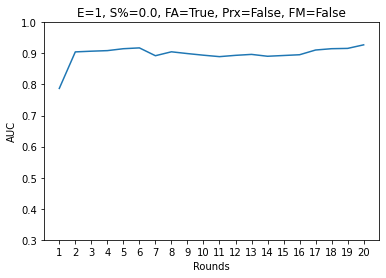

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 0% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 96.64s | Average gen_loss:22.07029804 | Average disc_loss:0.01496267
------------------------------------------------------------------------------------------
          | Test AUC = 0.66149 | Best AUC = 0.6614941830940178 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.62s | Average gen_loss:10.60996674 | Average disc_loss:0.00020468
------------------------------------------------------------------------------------------
          | Test AUC = 0.84657 | Best AUC = 0.8465734795726528 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.57s | Average gen_loss:9.16000143 | Average disc_loss:0.00012889
------------------------------------------------------------------------------------------
          | Test AUC =

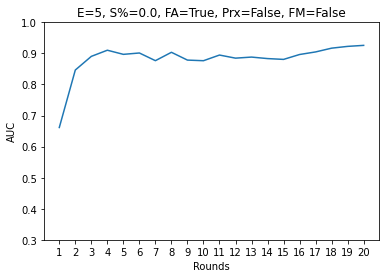

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 0% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 96.49s | Average gen_loss:21.98973932 | Average disc_loss:0.03433506
------------------------------------------------------------------------------------------
          | Test AUC = 0.68150 | Best AUC = 0.6814955530437135 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.60s | Average gen_loss:10.62065959 | Average disc_loss:0.00044019
------------------------------------------------------------------------------------------
          | Test AUC = 0.90011 | Best AUC = 0.9001052114942154 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.14s | Average gen_loss:9.12031379 | Average disc_loss:0.00026551
------------------------------------------------------------------------------------------
          | Test AUC 

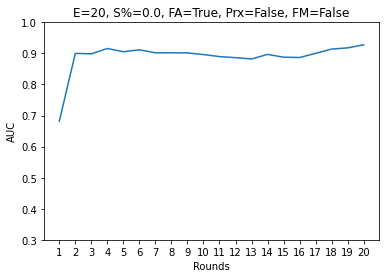

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 0% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

## FedAvg - 50% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 60.20s | Average gen_loss:22.49050091 | Average disc_loss:0.01671174
------------------------------------------------------------------------------------------
          | Test AUC = 0.76256 | Best AUC = 0.7625623262870059 
------------------------------------------------------------------------------------------
| Round:2 | time: 60.29s | Average gen_loss:12.37043645 | Average disc_loss:0.00015428
------------------------------------------------------------------------------------------
          | Test AUC = 0.82460 | Best AUC = 0.8245966999790894 
------------------------------------------------------------------------------------------
| Round:3 | time: 60.23s | Average gen_loss:11.04859091 | Average disc_loss:0.00003422
------------------------------------------------------------------------------------------
          | Test AUC 

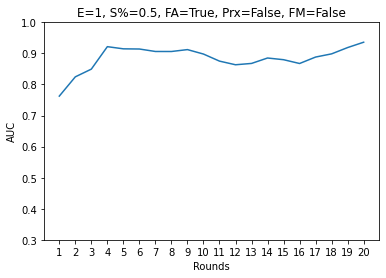

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 50% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 78.30s | Average gen_loss:30.84098215 | Average disc_loss:0.04827994
------------------------------------------------------------------------------------------
          | Test AUC = 0.67075 | Best AUC = 0.6707476472358656 
------------------------------------------------------------------------------------------
| Round:2 | time: 60.20s | Average gen_loss:11.01726698 | Average disc_loss:0.00030488
------------------------------------------------------------------------------------------
          | Test AUC = 0.89874 | Best AUC = 0.8987362093604343 
------------------------------------------------------------------------------------------
| Round:3 | time: 59.80s | Average gen_loss:9.27967794 | Average disc_loss:0.00019922
------------------------------------------------------------------------------------------
          | Test AUC =

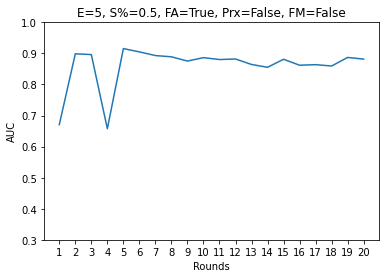

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 50% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 60.33s | Average gen_loss:22.04833632 | Average disc_loss:0.02242108
------------------------------------------------------------------------------------------
          | Test AUC = 0.69134 | Best AUC = 0.6913409061197404 
------------------------------------------------------------------------------------------
| Round:2 | time: 60.37s | Average gen_loss:10.81371259 | Average disc_loss:0.00031306
------------------------------------------------------------------------------------------
          | Test AUC = 0.90359 | Best AUC = 0.9035878468598602 
------------------------------------------------------------------------------------------
| Round:3 | time: 59.80s | Average gen_loss:13.71849667 | Average disc_loss:0.00007452
------------------------------------------------------------------------------------------
          | Test AUC

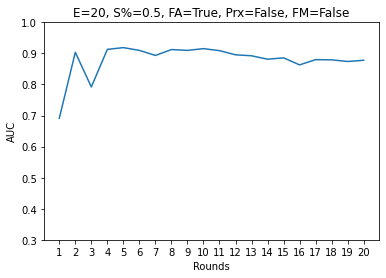

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 50% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

## FedAvg - 90% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 24.22s | Average gen_loss:22.29329168 | Average disc_loss:0.02151626
------------------------------------------------------------------------------------------
          | Test AUC = 0.72362 | Best AUC = 0.7236187438027042 
------------------------------------------------------------------------------------------
| Round:2 | time: 41.99s | Average gen_loss:36.03021215 | Average disc_loss:0.00007510
------------------------------------------------------------------------------------------
          | Test AUC = 0.89564 | Best AUC = 0.895638059290395 
------------------------------------------------------------------------------------------
| Round:3 | time: 41.58s | Average gen_loss:24.63500347 | Average disc_loss:0.00000132
------------------------------------------------------------------------------------------
          | Test AUC =

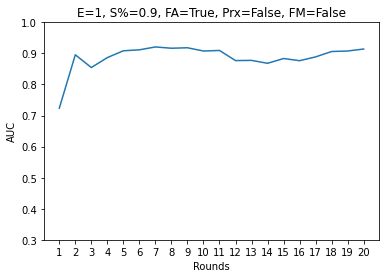

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 90% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 42.06s | Average gen_loss:44.22627425 | Average disc_loss:0.04394328
------------------------------------------------------------------------------------------
          | Test AUC = 0.69664 | Best AUC = 0.6966437276379401 
------------------------------------------------------------------------------------------
| Round:2 | time: 42.10s | Average gen_loss:34.40295366 | Average disc_loss:0.00007554
------------------------------------------------------------------------------------------
          | Test AUC = 0.89448 | Best AUC = 0.8944814234500055 
------------------------------------------------------------------------------------------
| Round:3 | time: 42.08s | Average gen_loss:20.00094318 | Average disc_loss:0.00000171
------------------------------------------------------------------------------------------
          | Test AUC 

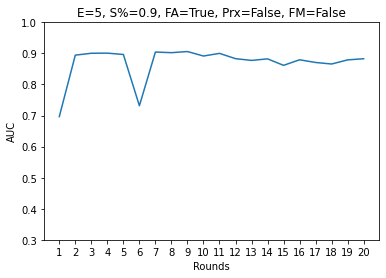

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 90% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 42.75s | Average gen_loss:45.92728873 | Average disc_loss:0.03437202
------------------------------------------------------------------------------------------
          | Test AUC = 0.73691 | Best AUC = 0.736908372046859 
------------------------------------------------------------------------------------------
| Round:2 | time: 45.06s | Average gen_loss:28.02956859 | Average disc_loss:0.00032306
------------------------------------------------------------------------------------------
          | Test AUC = 0.80647 | Best AUC = 0.8064684029855589 
------------------------------------------------------------------------------------------
| Round:3 | time: 62.62s | Average gen_loss:29.90027247 | Average disc_loss:0.00005618
------------------------------------------------------------------------------------------
          | Test AUC 

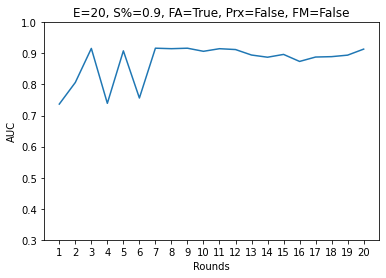

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedAvg, 90% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False
                                    )

# FEDPROX tune/test


## FedProx - 0% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 98.92s | Average gen_loss:9272.71513242 | Average disc_loss:9708.88525319
------------------------------------------------------------------------------------------
          | Test AUC = 0.69850 | Best AUC = 0.6984966046768444 
------------------------------------------------------------------------------------------
| Round:2 | time: 100.63s | Average gen_loss:8656.85926821 | Average disc_loss:9522.33477667
------------------------------------------------------------------------------------------
          | Test AUC = 0.91725 | Best AUC = 0.9172535206743556 
------------------------------------------------------------------------------------------
| Round:3 | time: 100.83s | Average gen_loss:8647.38259241 | Average disc_loss:9521.61387484
------------------------------------------------------------------------------------------
    

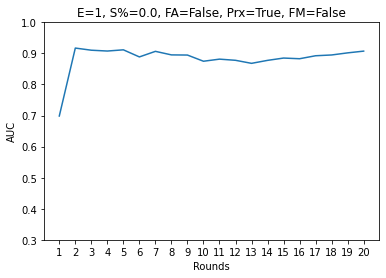

In [ ]:
### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 0% straggler, 1 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.0,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 97.00s | Average gen_loss:9271.93172134 | Average disc_loss:9706.72643103
------------------------------------------------------------------------------------------
          | Test AUC = 0.69145 | Best AUC = 0.6914513452649047 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.52s | Average gen_loss:8656.27915723 | Average disc_loss:9522.57589866
------------------------------------------------------------------------------------------
          | Test AUC = 0.91467 | Best AUC = 0.9146694791589377 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.48s | Average gen_loss:8645.19934191 | Average disc_loss:9521.45776606
------------------------------------------------------------------------------------------
      

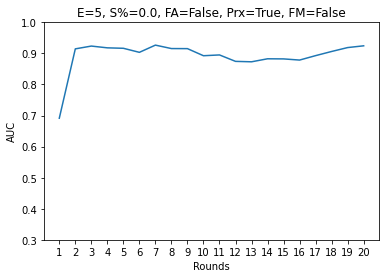

In [ ]:
### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 0% straggler, 5 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.0,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 96.46s | Average gen_loss:9269.55443510 | Average disc_loss:9702.77336123
------------------------------------------------------------------------------------------
          | Test AUC = 0.73784 | Best AUC = 0.7378386530102115 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.45s | Average gen_loss:8655.37308132 | Average disc_loss:9522.29436642
------------------------------------------------------------------------------------------
          | Test AUC = 0.90572 | Best AUC = 0.9057203751188869 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.60s | Average gen_loss:8644.83871294 | Average disc_loss:9521.41081780
------------------------------------------------------------------------------------------
     

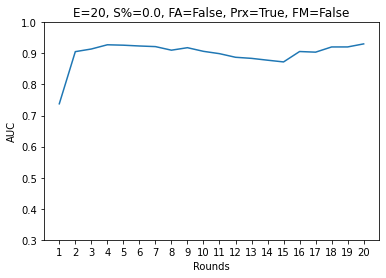

In [ ]:
### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 0% straggler, 20 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.0,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

## FedProx - 50% Stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 96.35s | Average gen_loss:9286.05013726 | Average disc_loss:9707.07700729
------------------------------------------------------------------------------------------
          | Test AUC = 0.71796 | Best AUC = 0.7179563948063328 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.58s | Average gen_loss:8654.76139055 | Average disc_loss:9522.28794667
------------------------------------------------------------------------------------------
          | Test AUC = 0.89114 | Best AUC = 0.8911388264943452 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.32s | Average gen_loss:8644.90193761 | Average disc_loss:9521.38622529
------------------------------------------------------------------------------------------
      

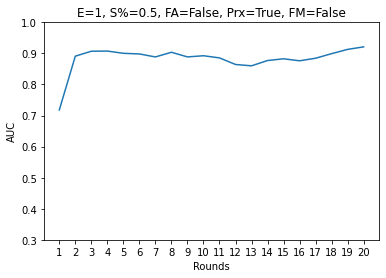

In [ ]:
### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 50% straggler, 1 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.5,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 96.03s | Average gen_loss:9270.52312637 | Average disc_loss:9700.30915835
------------------------------------------------------------------------------------------
          | Test AUC = 0.69615 | Best AUC = 0.6961549784100424 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.35s | Average gen_loss:8657.60073207 | Average disc_loss:9522.20932791
------------------------------------------------------------------------------------------
          | Test AUC = 0.89211 | Best AUC = 0.892113602717158 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.27s | Average gen_loss:8646.64640613 | Average disc_loss:9521.41977027
------------------------------------------------------------------------------------------
       

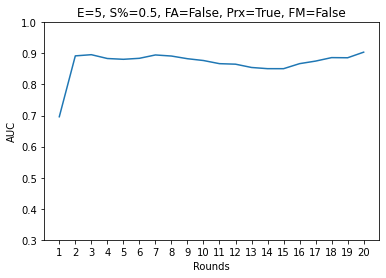

In [ ]:
### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 50% straggler, 5 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.5,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 95.95s | Average gen_loss:9260.22348047 | Average disc_loss:9703.58647970
------------------------------------------------------------------------------------------
          | Test AUC = 0.67730 | Best AUC = 0.6772963520793203 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.37s | Average gen_loss:8653.72090198 | Average disc_loss:9522.23230775
------------------------------------------------------------------------------------------
          | Test AUC = 0.90256 | Best AUC = 0.902560071410836 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.29s | Average gen_loss:8644.56791576 | Average disc_loss:9521.37238911
------------------------------------------------------------------------------------------
      

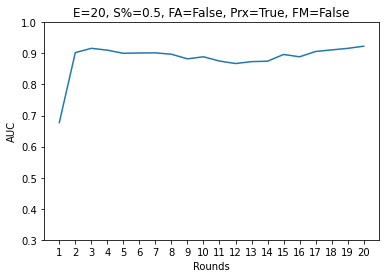

In [ ]:
### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 50% straggler, 20 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.5,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

## FedProx - 90% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 95.99s | Average gen_loss:9277.16878741 | Average disc_loss:9705.04898079
------------------------------------------------------------------------------------------
          | Test AUC = 0.73434 | Best AUC = 0.7343426232946696 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.29s | Average gen_loss:8656.83813026 | Average disc_loss:9522.63774427
------------------------------------------------------------------------------------------
          | Test AUC = 0.92690 | Best AUC = 0.9268952924802452 
------------------------------------------------------------------------------------------
| Round:3 | time: 95.68s | Average gen_loss:8645.37411527 | Average disc_loss:9521.66140859
------------------------------------------------------------------------------------------
      

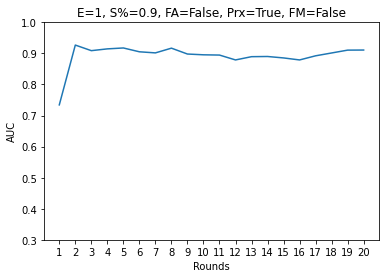

In [ ]:
### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 90% straggler, 1 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.9,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 94.17s | Average gen_loss:9274.53482020 | Average disc_loss:9708.25868567
------------------------------------------------------------------------------------------
          | Test AUC = 0.76011 | Best AUC = 0.7601054347333802 
------------------------------------------------------------------------------------------
| Round:2 | time: 98.05s | Average gen_loss:8657.27450290 | Average disc_loss:9522.26511499
------------------------------------------------------------------------------------------
          | Test AUC = 0.90608 | Best AUC = 0.9060814203021728 
------------------------------------------------------------------------------------------
| Round:3 | time: 99.58s | Average gen_loss:8646.32685457 | Average disc_loss:9521.45463862
------------------------------------------------------------------------------------------
      

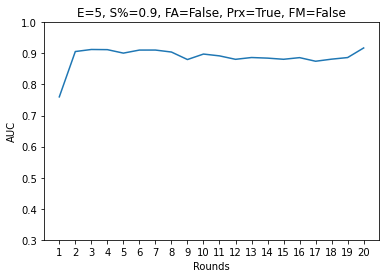

In [ ]:
# ### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 90% straggler, 5 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.9,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 98.33s | Average gen_loss:9256.84809275 | Average disc_loss:9703.38095798
------------------------------------------------------------------------------------------
          | Test AUC = 0.63289 | Best AUC = 0.632885297147389 
------------------------------------------------------------------------------------------
| Round:2 | time: 98.38s | Average gen_loss:8654.44577115 | Average disc_loss:9522.34046563
------------------------------------------------------------------------------------------
          | Test AUC = 0.90074 | Best AUC = 0.9007446953395692 
------------------------------------------------------------------------------------------
| Round:3 | time: 98.16s | Average gen_loss:8644.28758045 | Average disc_loss:9521.33093524
------------------------------------------------------------------------------------------
      

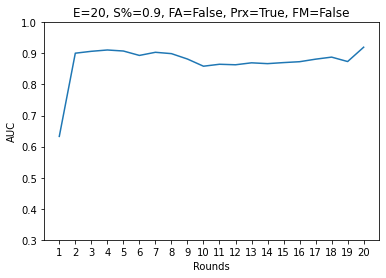

In [ ]:
### FEDPROX

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedProx, 90% straggler, 20 epoch
    # FedProx means fed_Avg=False and use_prox_term=True in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.9,
                                  fed_avg = False,
                                  use_prox_term = True
                                    )

## FedMed - 0% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 96.47s | Average gen_loss:22.25100899 | Average disc_loss:0.01991913
------------------------------------------------------------------------------------------
          | Test AUC = 0.68886 | Best AUC = 0.6888607029367674 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.72s | Average gen_loss:10.71493748 | Average disc_loss:0.00035395
------------------------------------------------------------------------------------------
          | Test AUC = 0.91445 | Best AUC = 0.9144477978500303 
------------------------------------------------------------------------------------------
| Round:3 | time: 95.88s | Average gen_loss:9.19442183 | Average disc_loss:0.00021061
------------------------------------------------------------------------------------------
          | Test AUC =

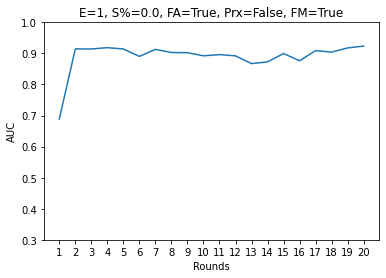

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 0% straggler, 1 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 96.56s | Average gen_loss:22.49267385 | Average disc_loss:0.03161667
------------------------------------------------------------------------------------------
          | Test AUC = 0.73824 | Best AUC = 0.73824157561239 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.27s | Average gen_loss:10.81695746 | Average disc_loss:0.00072326
------------------------------------------------------------------------------------------
          | Test AUC = 0.91195 | Best AUC = 0.9119545295547775 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.50s | Average gen_loss:9.14435021 | Average disc_loss:0.00039106
------------------------------------------------------------------------------------------
          | Test AUC = 0

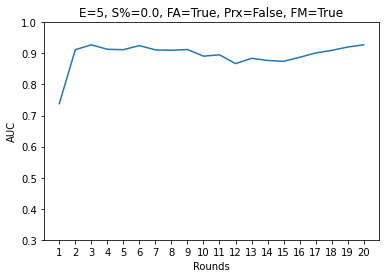

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 0% straggler, 5 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                           90
1
       opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 96.52s | Average gen_loss:22.67815584 | Average disc_loss:0.03080973
------------------------------------------------------------------------------------------
          | Test AUC = 0.52338 | Best AUC = 0.5233839572305881 
------------------------------------------------------------------------------------------
| Round:2 | time: 96.88s | Average gen_loss:10.65654035 | Average disc_loss:0.00054619
------------------------------------------------------------------------------------------
          | Test AUC = 0.87791 | Best AUC = 0.877913214891305 
------------------------------------------------------------------------------------------
| Round:3 | time: 96.43s | Average gen_loss:9.12842789 | Average disc_loss:0.00039765
------------------------------------------------------------------------------------------
          | Test AUC =

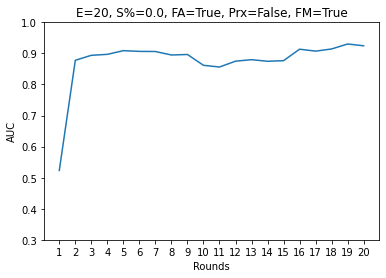

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 0% straggler, 20 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True
                                    )

## FedMed - 50% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 59.86s | Average gen_loss:22.10834762 | Average disc_loss:0.02860531
------------------------------------------------------------------------------------------
          | Test AUC = 0.68098 | Best AUC = 0.6809778710564158 
------------------------------------------------------------------------------------------
| Round:2 | time: 60.17s | Average gen_loss:12.65335069 | Average disc_loss:0.00030720
------------------------------------------------------------------------------------------
          | Test AUC = 0.90561 | Best AUC = 0.9056145212098085 
------------------------------------------------------------------------------------------
| Round:3 | time: 59.69s | Average gen_loss:9.15924304 | Average disc_loss:0.00022612
------------------------------------------------------------------------------------------
          | Test AUC =

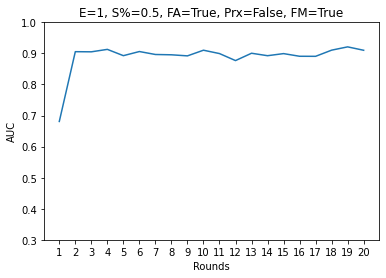

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 50% straggler, 1 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 78.35s | Average gen_loss:31.39174191 | Average disc_loss:0.04516577
------------------------------------------------------------------------------------------
          | Test AUC = 0.77602 | Best AUC = 0.7760203073762396 
------------------------------------------------------------------------------------------
| Round:2 | time: 60.42s | Average gen_loss:13.04281140 | Average disc_loss:0.00033970
------------------------------------------------------------------------------------------
          | Test AUC = 0.91736 | Best AUC = 0.9173567406824952 
------------------------------------------------------------------------------------------
| Round:3 | time: 77.80s | Average gen_loss:12.26005493 | Average disc_loss:0.00043167
------------------------------------------------------------------------------------------
          | Test AUC 

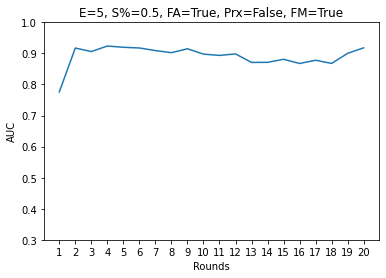

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 50% straggler, 5 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True                    
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 60.21s | Average gen_loss:22.29901030 | Average disc_loss:0.02459025
------------------------------------------------------------------------------------------
          | Test AUC = 0.71993 | Best AUC = 0.7199335630608884 
------------------------------------------------------------------------------------------
| Round:2 | time: 78.40s | Average gen_loss:16.44117828 | Average disc_loss:0.00027640
------------------------------------------------------------------------------------------
          | Test AUC = 0.89189 | Best AUC = 0.8918937442604247 
------------------------------------------------------------------------------------------
| Round:3 | time: 60.34s | Average gen_loss:11.52890632 | Average disc_loss:0.00013545
------------------------------------------------------------------------------------------
          | Test AUC

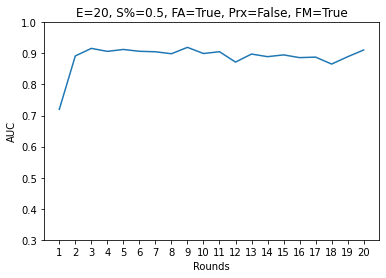

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 50% straggler, 20 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True
                                    )

## FedMed - 90% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 23.81s | Average gen_loss:22.30304343 | Average disc_loss:0.03274368
------------------------------------------------------------------------------------------
          | Test AUC = 0.75096 | Best AUC = 0.750955873165464 
------------------------------------------------------------------------------------------
| Round:2 | time: 60.10s | Average gen_loss:50.24475998 | Average disc_loss:0.00009103
------------------------------------------------------------------------------------------
          | Test AUC = 0.89516 | Best AUC = 0.8951560313280033 
------------------------------------------------------------------------------------------
| Round:3 | time: 41.92s | Average gen_loss:19.60904427 | Average disc_loss:0.00000227
------------------------------------------------------------------------------------------
          | Test AUC =

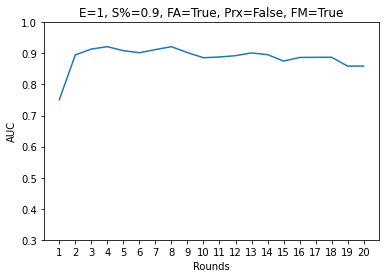

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 90% straggler, 1 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 42.05s | Average gen_loss:45.15967557 | Average disc_loss:0.03471890
------------------------------------------------------------------------------------------
          | Test AUC = 0.70514 | Best AUC = 0.705142787945599 
------------------------------------------------------------------------------------------
| Round:2 | time: 60.30s | Average gen_loss:42.70225025 | Average disc_loss:0.00032466
------------------------------------------------------------------------------------------
          | Test AUC = 0.78829 | Best AUC = 0.7882934586427766 
------------------------------------------------------------------------------------------
| Round:3 | time: 24.09s | Average gen_loss:9.58177074 | Average disc_loss:0.00001504
------------------------------------------------------------------------------------------
          | Test AUC = 

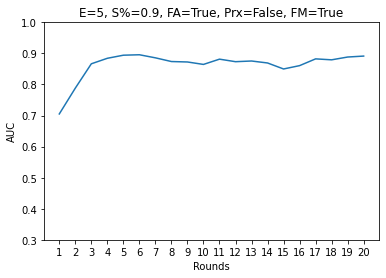

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 90% straggler, 5 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 42.21s | Average gen_loss:43.74196038 | Average disc_loss:0.02777656
------------------------------------------------------------------------------------------
          | Test AUC = 0.63065 | Best AUC = 0.6306523032339486 
------------------------------------------------------------------------------------------
| Round:2 | time: 60.20s | Average gen_loss:38.75272776 | Average disc_loss:0.00046224
------------------------------------------------------------------------------------------
          | Test AUC = 0.88445 | Best AUC = 0.8844522594212548 
------------------------------------------------------------------------------------------
| Round:3 | time: 41.54s | Average gen_loss:25.77729226 | Average disc_loss:0.00010326
------------------------------------------------------------------------------------------
          | Test AUC

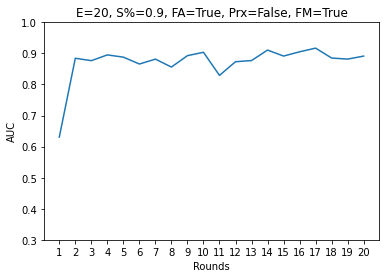

In [ ]:
### FEDMED

# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedMed, 90% straggler, 20 epoch
    # FedMed means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med = True
                                    )

## FedPer (fedper_layer = Disc)

### 0% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 125.20s | Average gen_loss:22.97551731 | Average disc_loss:0.02698228
------------------------------------------------------------------------------------------
          | Test AUC = 0.73733 | Best AUC = 0.7373289482094775 
------------------------------------------------------------------------------------------
| Round:2 | time: 125.08s | Average gen_loss:10.87344854 | Average disc_loss:0.00050191
------------------------------------------------------------------------------------------
          | Test AUC = 0.91533 | Best AUC = 0.9153293901909032 
------------------------------------------------------------------------------------------
| Round:3 | time: 124.67s | Average gen_loss:9.17957592 | Average disc_loss:0.00026537
------------------------------------------------------------------------------------------
          | Test AU

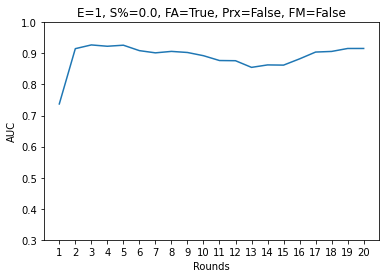

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 0% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 125.10s | Average gen_loss:21.70592679 | Average disc_loss:0.02411823
------------------------------------------------------------------------------------------
          | Test AUC = 0.74612 | Best AUC = 0.7461151390523032 
------------------------------------------------------------------------------------------
| Round:2 | time: 124.69s | Average gen_loss:10.51710899 | Average disc_loss:0.00041510
------------------------------------------------------------------------------------------
          | Test AUC = 0.90373 | Best AUC = 0.9037325845345687 
------------------------------------------------------------------------------------------
| Round:3 | time: 124.41s | Average gen_loss:9.13299459 | Average disc_loss:0.00023895
------------------------------------------------------------------------------------------
          | Test AU

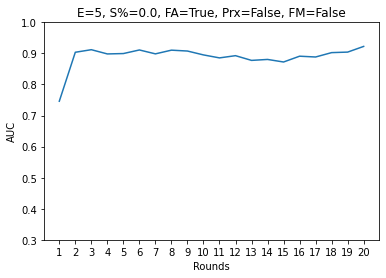

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 0% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 124.71s | Average gen_loss:23.14663724 | Average disc_loss:0.01555188
------------------------------------------------------------------------------------------
          | Test AUC = 0.80885 | Best AUC = 0.8088508707772866 
------------------------------------------------------------------------------------------
| Round:2 | time: 124.72s | Average gen_loss:10.90001393 | Average disc_loss:0.00025547
------------------------------------------------------------------------------------------
          | Test AUC = 0.89855 | Best AUC = 0.8985478854432968 
------------------------------------------------------------------------------------------
| Round:3 | time: 124.39s | Average gen_loss:9.17069828 | Average disc_loss:0.00021812
------------------------------------------------------------------------------------------
          | Test A

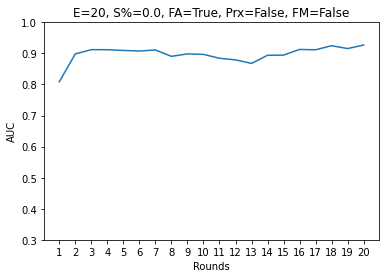

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 0% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

### 50% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 81.95s | Average gen_loss:23.56755401 | Average disc_loss:0.01946206
------------------------------------------------------------------------------------------
          | Test AUC = 0.74556 | Best AUC = 0.7455623956678111 
------------------------------------------------------------------------------------------
| Round:2 | time: 81.84s | Average gen_loss:14.96078099 | Average disc_loss:0.01676248
------------------------------------------------------------------------------------------
          | Test AUC = 0.78357 | Best AUC = 0.7835678388489467 
------------------------------------------------------------------------------------------
| Round:3 | time: 100.46s | Average gen_loss:13.28962222 | Average disc_loss:0.00760604
------------------------------------------------------------------------------------------
          | Test AUC

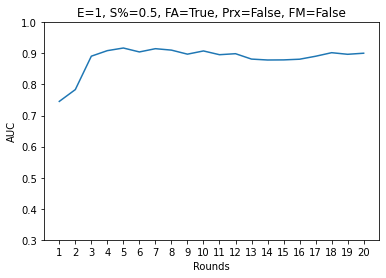

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 50% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 82.09s | Average gen_loss:21.89668833 | Average disc_loss:0.02796508
------------------------------------------------------------------------------------------
          | Test AUC = 0.63795 | Best AUC = 0.637947813749798 
------------------------------------------------------------------------------------------
| Round:2 | time: 82.30s | Average gen_loss:14.81097413 | Average disc_loss:0.01505770
------------------------------------------------------------------------------------------
          | Test AUC = 0.78053 | Best AUC = 0.7805347541622861 
------------------------------------------------------------------------------------------
| Round:3 | time: 100.27s | Average gen_loss:13.28240291 | Average disc_loss:0.01121082
------------------------------------------------------------------------------------------
          | Test AUC 

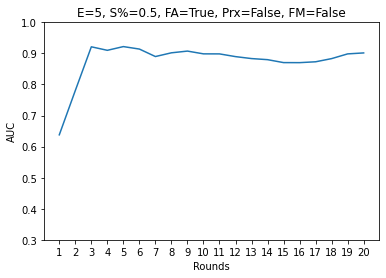

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 50% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 82.08s | Average gen_loss:22.89046192 | Average disc_loss:0.02622295
------------------------------------------------------------------------------------------
          | Test AUC = 0.72291 | Best AUC = 0.7229065723216199 
------------------------------------------------------------------------------------------
| Round:2 | time: 82.11s | Average gen_loss:10.79067832 | Average disc_loss:0.00039157
------------------------------------------------------------------------------------------
          | Test AUC = 0.88840 | Best AUC = 0.8883964281091193 
------------------------------------------------------------------------------------------
| Round:3 | time: 81.47s | Average gen_loss:11.13172555 | Average disc_loss:0.02019608
------------------------------------------------------------------------------------------
          | Test AUC

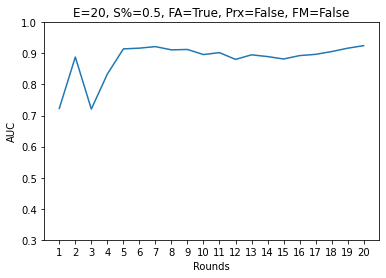

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 50% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

### 90% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 63.89s | Average gen_loss:45.95055105 | Average disc_loss:0.06115708
------------------------------------------------------------------------------------------
          | Test AUC = 0.77906 | Best AUC = 0.7790594789437286 
------------------------------------------------------------------------------------------
| Round:2 | time: 63.63s | Average gen_loss:27.45209396 | Average disc_loss:0.03010148
------------------------------------------------------------------------------------------
          | Test AUC = 0.79829 | Best AUC = 0.798291489641221 
------------------------------------------------------------------------------------------
| Round:3 | time: 82.01s | Average gen_loss:38.35025286 | Average disc_loss:0.15783661
------------------------------------------------------------------------------------------
          | Test AUC =

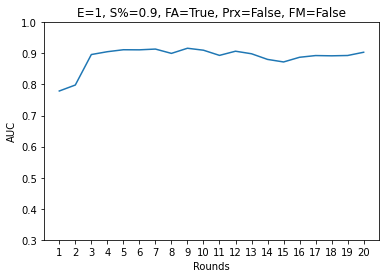

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 90% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 63.90s | Average gen_loss:44.29080238 | Average disc_loss:0.05309971
------------------------------------------------------------------------------------------
          | Test AUC = 0.68743 | Best AUC = 0.6874259432175928 
------------------------------------------------------------------------------------------
| Round:2 | time: 63.80s | Average gen_loss:27.41522272 | Average disc_loss:0.01583995
------------------------------------------------------------------------------------------
          | Test AUC = 0.77450 | Best AUC = 0.7744999763912539 
------------------------------------------------------------------------------------------
| Round:3 | time: 63.76s | Average gen_loss:19.68241108 | Average disc_loss:0.03983952
------------------------------------------------------------------------------------------
          | Test AUC 

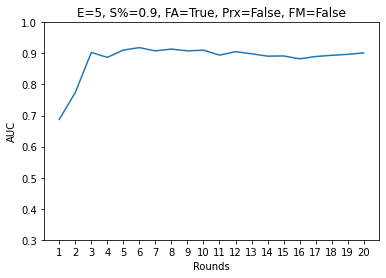

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 90% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 63.70s | Average gen_loss:45.98875037 | Average disc_loss:0.05554985
------------------------------------------------------------------------------------------
          | Test AUC = 0.77106 | Best AUC = 0.7710640477982357 
------------------------------------------------------------------------------------------
| Round:2 | time: 63.67s | Average gen_loss:34.17644226 | Average disc_loss:0.07254723
------------------------------------------------------------------------------------------
          | Test AUC = 0.89164 | Best AUC = 0.89163549990958 
------------------------------------------------------------------------------------------
| Round:3 | time: 82.06s | Average gen_loss:29.55784681 | Average disc_loss:0.02085125
------------------------------------------------------------------------------------------
          | Test AUC =

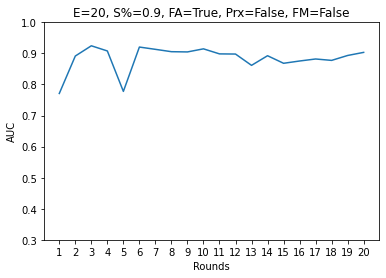

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (disc), 90% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="disc"
                                    )

## FedPer (fedper_layer = Gen)

In [ ]:
### 50% stragglers

### 0% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 118.61s | Average gen_loss:22.45283543 | Average disc_loss:0.03349631
------------------------------------------------------------------------------------------
          | Test AUC = 0.71525 | Best AUC = 0.7152548732788501 
------------------------------------------------------------------------------------------
| Round:2 | time: 118.60s | Average gen_loss:10.55929551 | Average disc_loss:0.00077570
------------------------------------------------------------------------------------------
          | Test AUC = 0.87523 | Best AUC = 0.8752321157323223 
------------------------------------------------------------------------------------------
| Round:3 | time: 118.62s | Average gen_loss:9.25561944 | Average disc_loss:0.00055579
------------------------------------------------------------------------------------------
          | Test AU

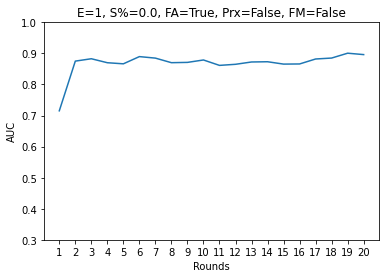

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 0% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 118.46s | Average gen_loss:22.14907946 | Average disc_loss:0.02259663
------------------------------------------------------------------------------------------
          | Test AUC = 0.73996 | Best AUC = 0.7399580326430264 
------------------------------------------------------------------------------------------
| Round:2 | time: 118.65s | Average gen_loss:10.47138048 | Average disc_loss:0.00035051
------------------------------------------------------------------------------------------
          | Test AUC = 0.89458 | Best AUC = 0.8945809206640127 
------------------------------------------------------------------------------------------
| Round:3 | time: 117.88s | Average gen_loss:9.15694848 | Average disc_loss:0.00024797
------------------------------------------------------------------------------------------
          | Test AU

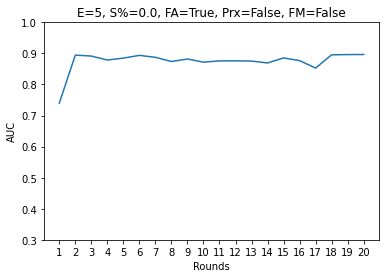

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 0% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 118.34s | Average gen_loss:21.86979857 | Average disc_loss:0.02960488
------------------------------------------------------------------------------------------
          | Test AUC = 0.63806 | Best AUC = 0.6380588888856767 
------------------------------------------------------------------------------------------
| Round:2 | time: 118.37s | Average gen_loss:10.39886135 | Average disc_loss:0.00053565
------------------------------------------------------------------------------------------
          | Test AUC = 0.89957 | Best AUC = 0.8995683775138096 
------------------------------------------------------------------------------------------
| Round:3 | time: 118.22s | Average gen_loss:9.14702307 | Average disc_loss:0.00031991
------------------------------------------------------------------------------------------
          | Test A

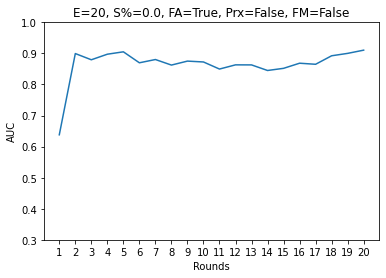

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 0% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.0,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

### 50% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 100.83s | Average gen_loss:30.32427736 | Average disc_loss:0.04976587
------------------------------------------------------------------------------------------
          | Test AUC = 0.75917 | Best AUC = 0.7591748084720387 
------------------------------------------------------------------------------------------
| Round:2 | time: 81.70s | Average gen_loss:10.59829523 | Average disc_loss:0.00081134
------------------------------------------------------------------------------------------
          | Test AUC = 0.83477 | Best AUC = 0.8347654655757177 
------------------------------------------------------------------------------------------
| Round:3 | time: 81.89s | Average gen_loss:13.73673655 | Average disc_loss:0.00035128
------------------------------------------------------------------------------------------
          | Test AUC

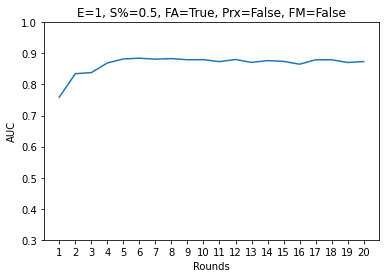

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 50% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 82.16s | Average gen_loss:22.72050774 | Average disc_loss:0.03375335
------------------------------------------------------------------------------------------
          | Test AUC = 0.76760 | Best AUC = 0.7675986468173323 
------------------------------------------------------------------------------------------
| Round:2 | time: 82.19s | Average gen_loss:14.70304665 | Average disc_loss:0.00038350
------------------------------------------------------------------------------------------
          | Test AUC = 0.82536 | Best AUC = 0.8253571248465832 
------------------------------------------------------------------------------------------
| Round:3 | time: 82.09s | Average gen_loss:14.25709987 | Average disc_loss:0.00036373
------------------------------------------------------------------------------------------
          | Test AUC 

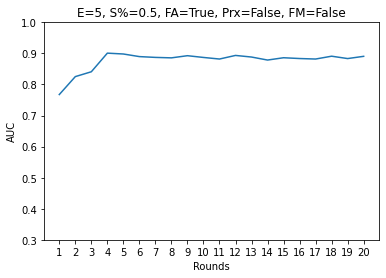

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 50% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 81.43s | Average gen_loss:22.65097111 | Average disc_loss:0.02926477
------------------------------------------------------------------------------------------
          | Test AUC = 0.72461 | Best AUC = 0.7246106066548398 
------------------------------------------------------------------------------------------
| Round:2 | time: 81.59s | Average gen_loss:18.65042468 | Average disc_loss:0.00010315
------------------------------------------------------------------------------------------
          | Test AUC = 0.73485 | Best AUC = 0.7348464178786627 
------------------------------------------------------------------------------------------
| Round:3 | time: 99.88s | Average gen_loss:13.68828964 | Average disc_loss:0.02327500
------------------------------------------------------------------------------------------
          | Test AUC

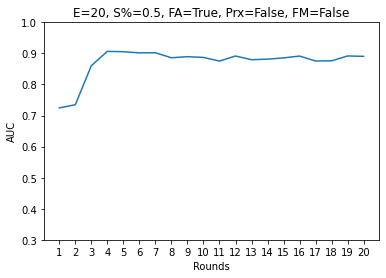

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 50% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.5,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

### 90% stragglers

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 1 epochs each round
| Round:1 | time: 63.55s | Average gen_loss:43.36504843 | Average disc_loss:0.05150421
------------------------------------------------------------------------------------------
          | Test AUC = 0.75307 | Best AUC = 0.7530749926202593 
------------------------------------------------------------------------------------------
| Round:2 | time: 81.89s | Average gen_loss:42.24074824 | Average disc_loss:0.00088441
------------------------------------------------------------------------------------------
          | Test AUC = 0.79789 | Best AUC = 0.7978907608858001 
------------------------------------------------------------------------------------------
| Round:3 | time: 63.47s | Average gen_loss:31.97898112 | Average disc_loss:0.00000093
------------------------------------------------------------------------------------------
          | Test AUC 

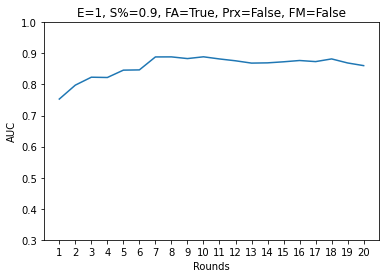

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 90% straggler, 1 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 1,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 5 epochs each round
| Round:1 | time: 63.26s | Average gen_loss:44.96722962 | Average disc_loss:0.05927452
------------------------------------------------------------------------------------------
          | Test AUC = 0.77363 | Best AUC = 0.7736258890620198 
------------------------------------------------------------------------------------------
| Round:2 | time: 62.89s | Average gen_loss:45.40339941 | Average disc_loss:0.00000658
------------------------------------------------------------------------------------------
          | Test AUC = 0.74471 | Best AUC = 0.7736258890620198 
------------------------------------------------------------------------------------------
| Round:3 | time: 63.09s | Average gen_loss:33.04746008 | Average disc_loss:0.00018535
------------------------------------------------------------------------------------------
          | Test AUC 

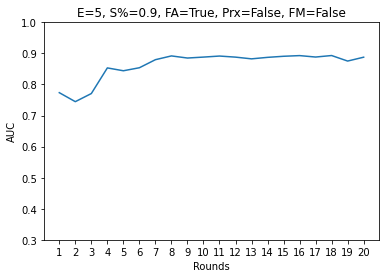

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 90% straggler, 5 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 5,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

train_ds len 54077
valid_ds len 15923
Training Federated-model with: dataset = mnist & abnormal_class = 0 & update 20 epochs each round
| Round:1 | time: 63.46s | Average gen_loss:44.87621767 | Average disc_loss:0.04313568
------------------------------------------------------------------------------------------
          | Test AUC = 0.70403 | Best AUC = 0.7040254421982408 
------------------------------------------------------------------------------------------
| Round:2 | time: 82.04s | Average gen_loss:43.40689063 | Average disc_loss:0.00078111
------------------------------------------------------------------------------------------
          | Test AUC = 0.77337 | Best AUC = 0.7733709932986493 
------------------------------------------------------------------------------------------
| Round:3 | time: 81.49s | Average gen_loss:29.32438588 | Average disc_loss:0.02513698
------------------------------------------------------------------------------------------
          | Test AUC

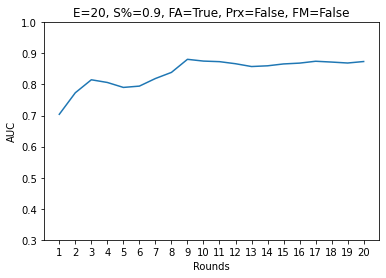

In [ ]:
# Tune/Test
# the statics are batchsize = 256, clients = 5, rounds = 20
    # batchsize and clients due to computational limits, rounds due to google OG paper needing 18 rounds to get
    # 99% acc using cnn on federated img recognition
    
    
# FedPer (gen), 90% straggler, 20 epoch
    # FedAvg means fed_Avg=True and use_prox_term=False in f_t_fp_p

gc.collect()
torch.cuda.empty_cache()

lambda_dic = {
    'lambda_adv' : 1,
    'lambda_con' : 20,
    'lambda_enc' : 20
}    
num_clients = 5
# num_clients = 100
opt_gen = OPT(imageSize=32, nz=100, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
opt_disc = OPT(imageSize=32, nz=1, nc=1, ngf=128, ngpu=0, n_extra_layers=0)
train_dl, valid_dl = load_FL_data(dataset = 'mnist',
                                  abnormal_class = 0,
                                  image_size = 32,
                                  batch_size = 256,
                                  num_clients = num_clients
                                  )

mnist_fl_best_auc_0 = federated_train_fedprox_partial(lambda_dic = lambda_dic,
                                  dataset = 'mnist',
                                  abnormal_class = 0,
                                  opt_gen = opt_gen,
                                  opt_disc = opt_disc,
                                  train_dl = train_dl,
                                  valid_dl = valid_dl,
                                  num_clients = num_clients,
                                  lr = 0.0001,               
                                  # num_rounds = 50,
                                  num_rounds = 20,
                                  n_epoches = 20,
                                  straggler_percentage = 0.9,
                                  fed_avg = True,
                                  use_prox_term = False,
                                  fed_med=False,
                                  fedper_layer="gen"
                                    )

## Cifar10

In [ ]:
# lambda_dic = {
#     'lambda_adv' : 1,
#     'lambda_con' : 20,
#     'lambda_enc' : 20
# }    
# num_clients = 5
# opt_gen = OPT(imageSize=64, nz=100, nc=3, ngf=64, ngpu=0, n_extra_layers=0)
# opt_disc = OPT(imageSize=64, nz=1, nc=3, ngf=64, ngpu=0, n_extra_layers=0)
# train_dl, valid_dl = load_FL_data(dataset = 'cifar10',
#                                   abnormal_class = 'truck',
#                                   image_size = 64,
#                                   batch_size = 256,
#                                   num_clients = num_clients
#                                   )
# mnist_fl_best_auc_0 = federated_train(lambda_dic = lambda_dic,
#                                   dataset = 'cifar10',
#                                   abnormal_class = 'truck',
#                                   opt_gen = opt_gen,
#                                   opt_disc = opt_disc,
#                                   train_dl = train_dl,
#                                   valid_dl = valid_dl,
#                                   num_clients = num_clients,
#                                   lr = 0.0002,               
#                                   num_rounds = 30,
#                                     n_epoches = 1
#                                     )

## Compass

In [ ]:
# lambda_dic = {
#     'lambda_adv' : 1,
#     'lambda_con' : 20,
#     'lambda_enc' : 20
# }    
# num_clients = 3
# opt_gen = OPT(imageSize=128, nz=100, nc=3, ngf=128, ngpu=0, n_extra_layers=0)
# opt_disc = OPT(imageSize=128, nz=1, nc=3, ngf=128, ngpu=0, n_extra_layers=0)
# train_dl, valid_dl = load_FL_data(dataset = 'compass',
#                                   abnormal_class = '',
#                                   image_size = 128,
#                                   batch_size = 64,
#                                   num_clients = num_clients
#                                   )
# mnist_fl_best_auc_0 = federated_train(lambda_dic = lambda_dic,
#                                   dataset = 'compass',
#                                   abnormal_class = '',
#                                   opt_gen = opt_gen,
#                                   opt_disc = opt_disc,
#                                   train_dl = train_dl,
#                                   valid_dl = valid_dl,
#                                   num_clients = num_clients,
#                                   lr = 0.001,               
#                                   num_rounds = 30,
#                                     n_epoches = 1
#                                     )